## Trabajo Practico N°2

- Alvez Paula
- Bustos Daniel


Importamos las dependecias necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

from sklearn import linear_model   # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score ,accuracy_score   # Medidas de desempeño
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder  # Herramientas de polinomios

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from formulaic import model_matrix
from formulaic import Formula

# Paquetes para clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

#Paquetes para redes Neurnales
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
import keras



### 1. Preprocesamiento

1..1 Cargar en un DataFrame los datos del archivo FBRef2020-21.csv.

In [2]:
FBRef = pd.read_csv("FBRef2020-21.csv")
display(FBRef.head())

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,22,20,1777,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,33,33,2889,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,Pape Abou Cisse,sn SEN,DF,Saint-Étienne,fr Ligue 1,24.0,1995.0,14,14,1260,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,34.0,1986.0,14,14,1222,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,Francesco Acerbi,it ITA,DF,Lazio,it Serie A,32.0,1988.0,32,32,2813,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


2. Eliminar a los jugadores que jugaron menos de 500 minutos en la temporada (columna Min).

In [3]:
FBRef = FBRef.drop(FBRef[FBRef["Min"] < 500 ].index)

3. Eliminar los datos faltantes. Por ejemplo, eliminar columnas con más de 100 datos faltantes y
luego las filas con datos faltantes, o convertir los datos faltantes a algún valor apropiado.

In [4]:
cuenta_faltante = FBRef.isnull().sum()
#Recuperamos los indices de aquellas columnas que tienen mas de 100 datos faltantes
a_tirar = cuenta_faltante[cuenta_faltante > 100].index

FBRef = FBRef.drop(columns = a_tirar)
#Los datos restantes faltantes los convertimos en 0's
FBRef = FBRef.dropna()

4. Al finalizar la limpieza de datos, resetear los índices.

In [5]:
FBRef = FBRef.reset_index(drop=True)
display(FBRef.head())

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,22,20,1777,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,33,33,2889,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,Pape Abou Cisse,sn SEN,DF,Saint-Étienne,fr Ligue 1,24.0,1995.0,14,14,1260,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,34.0,1986.0,14,14,1222,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,Francesco Acerbi,it ITA,DF,Lazio,it Serie A,32.0,1988.0,32,32,2813,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


5. Definir el DataFrame data_num que solo contenga las variables númericas, a partir de la
columna Ast/90, inclusive. Para clustering y clasificación no vamos a utilizar las variables
categóricas ni edad ni minutos jugados

In [6]:
#Recuperamos el indice de la primera columna que queremos  que este
indiceInicioCol = FBRef.columns.get_loc("Ast/90")
#Cortamos el dataset en base a este indice
data_num = FBRef.iloc[:,indiceInicioCol:]
display(data_num.head())


,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,FKSht/90,np:G-xG,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,0.05,0.00,0.05,0.04,0.06,0.10,0.91,0.30,0.15,-0.06,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,0.00,0.09,0.09,0.01,0.05,0.06,0.47,0.16,0.00,0.04,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,0.00,0.00,0.00,0.00,0.08,0.09,0.93,0.21,0.00,-0.09,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,0.00,0.07,0.07,0.03,0.05,0.08,0.66,0.15,0.00,0.02,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,0.03,0.00,0.03,0.03,0.03,0.06,0.26,0.00,0.00,-0.03,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


### 2. Clustering


6. Nuestro primer objetivo es realizar algún agrupamiento de jugadores con características similares.

(a) Seleccionar dos variables cualesquiera de los datos y realizar un gráfico de dispersión de
una variable en función de la otra para el total de las observaciones. ¿Pueden encontrar
fácilmente grupos distintos?

Vamos a elegir las variables: Distancia Llevada de Pelota en 90 minutos y los Tiros Al arco en 90 Minutos

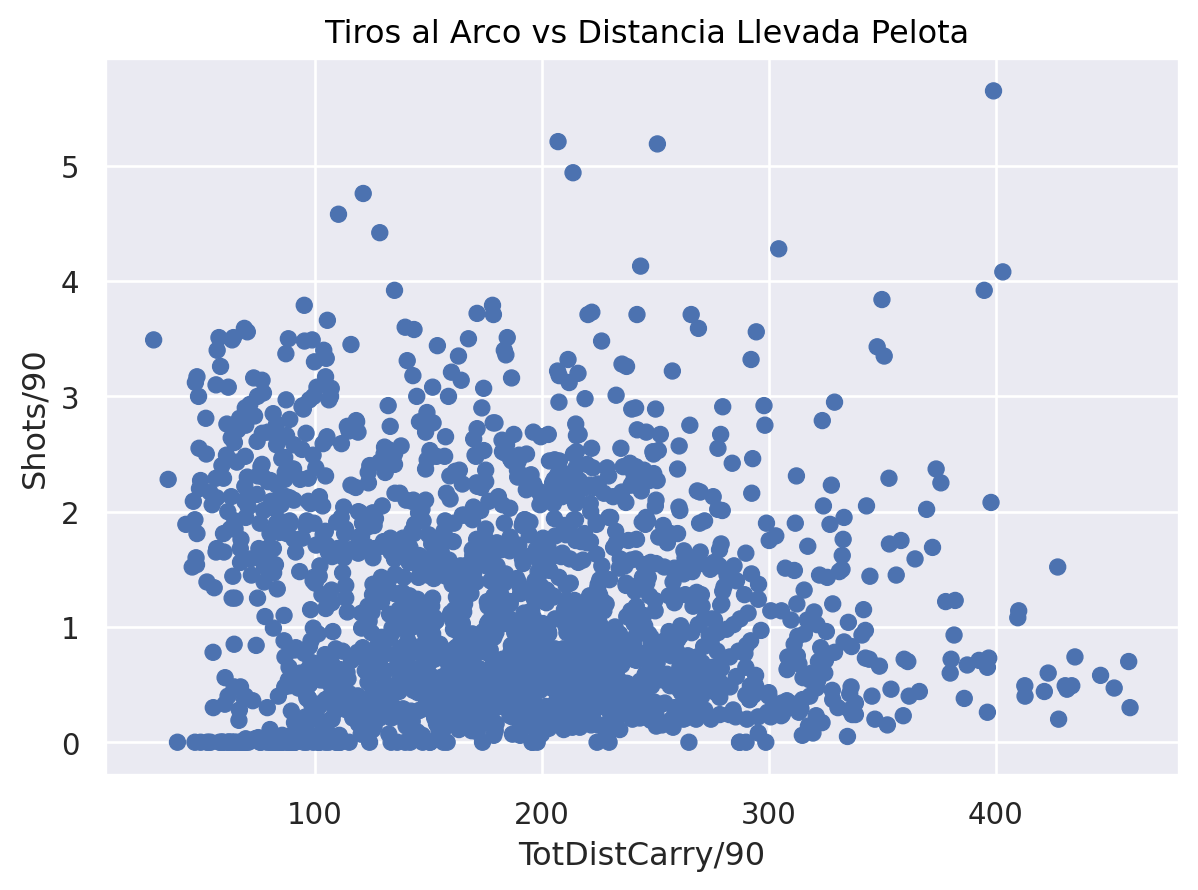

In [7]:
dataX =  "TotDistCarry/90"

dataY = "Shots/90"
so.Plot(data_num,x =dataX, y = dataY).add(so.Dot()).label(title= " Tiros al Arco vs Distancia Llevada Pelota")

No es extremadamente evidente que haya algun cluster particular, los datos estan demasiado juntos . No obstante es importante tener en cuenta la diferencia de escala entre ambos. A priori no pareciera que llevar mas tiempo la pelota implique *necesariamente* una cantidad mayor de goles

b) Escalar los datos y realizar un análisis de componentes principales, quedándose solo con
las dos primeras componentes. Realizar un gráfico como el del punto anterior. ¿Cuántos
clusters puede distinguir en el gráfico? 

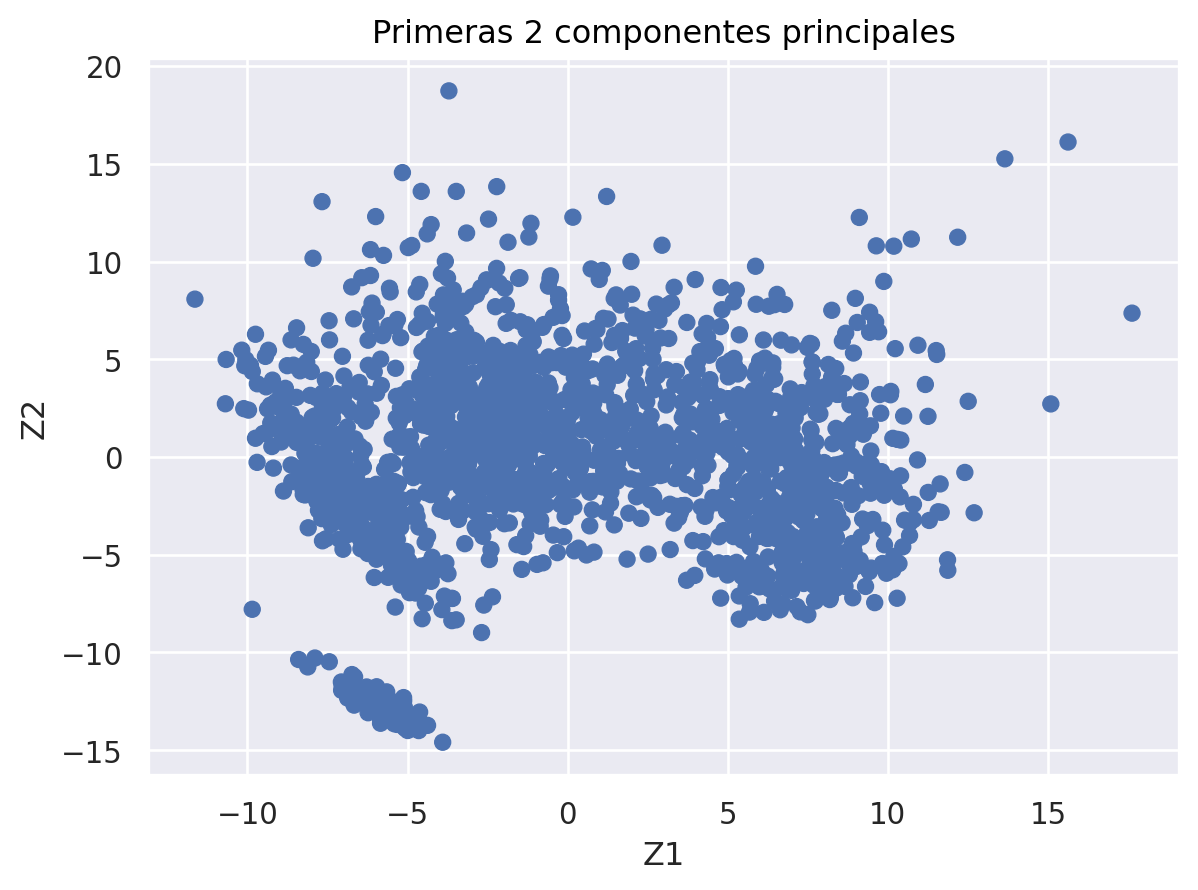

In [8]:
#Realizamos escalamiento min-Max

# Como tenemos datos en distintas escalas llevamos los datos a media 0 y varianza 1.
# Esta normalización se obtiene restando la media y dividiendo por el desvío estandar.
# El proceso lo realiza el StandardScaler de sklearn
df_scaled =StandardScaler().fit_transform(data_num)
#Los llevamos a media 0

#Utilizamos PCA
myPCA = PCA(n_components=2)

CompPrincipales = pd.DataFrame(myPCA.fit_transform(df_scaled)).rename(columns = {0:"Z1",1:"Z2"})



so.Plot(CompPrincipales, x = "Z1", y = "Z2").add(so.Dot()).label(title= "Primeras 2 componentes principales")



Parece que obtenemos dos  o tres grandes clusters! Es interesante observar que estos no tienen la misma forma ni densidad entre ellos. Antes de sacar conclusiones, miremos que porcentaje de la varianza total estamos podiendo representar tan solo con dos componentes principales

In [9]:

print("Estamos explicando el {0:0.2f} % de la variabilidad total ".format(myPCA.explained_variance_ratio_.sum()*100))

Estamos explicando el 49.15 % de la variabilidad total 


Apenas un poco mas de la mitad!. Esto nos induce a pensar que nuestros datos tienen una variabilidad muy alta en cada metrica. No obstante los clusters podrian estar dados por muchas razones, por ejemplo que haya una pequeña cantidad de jugadores cuyo desempeño sea muy superior al de los demas o viceversa

(c) Para la cantidad de clusters observados en el ítem anterior, realizar un agrupamiento por
k-medias, y colorear los puntos según las etiquetas obtenidas. ¿Coinciden las etiquetas
con lo esperado?

Dado que los aparentes clustes no son isotropicos ni tienen mismo radio, seguro k-means no nos dara el resultado esperado. No obstante lo utilizamos 

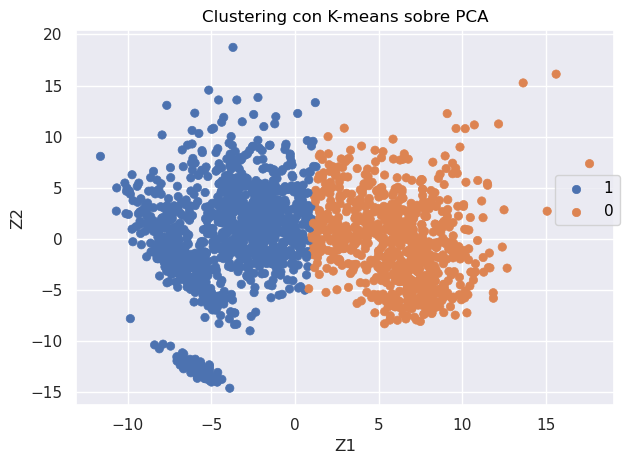

In [10]:
k = KMeans(n_clusters=2)
k.fit(CompPrincipales)
etiquetas = k.predict(CompPrincipales)
so.Plot(CompPrincipales, x = "Z1",y= "Z2", color = etiquetas.astype("str")).add(so.Dot()).label(title  = "Clustering con K-means sobre PCA").show()


En efecto, el etiqueado es medio brusco, dado la naturaleza del metodo que estamos utilizando

(d) Repetir el agrupamiento utilizando DBSCAN. ¿Cómo eligirían en este caso un valor de ε
apropiado?

Para tomar el epislon apropiado haremos lo siguiente:
- Calculamos la distancia de cada nodo a su vecino mas Cercano
- Graficamos estas distancias en orden creciente
- Usando el "metodo del codo": nos fijamos la distancia mas grande posible tal que el grafico no crezca extremadamente rapido, de esta manera tomamos la mayor cantidad de puntos posibles, sin necesariamente abarcar a los outliers

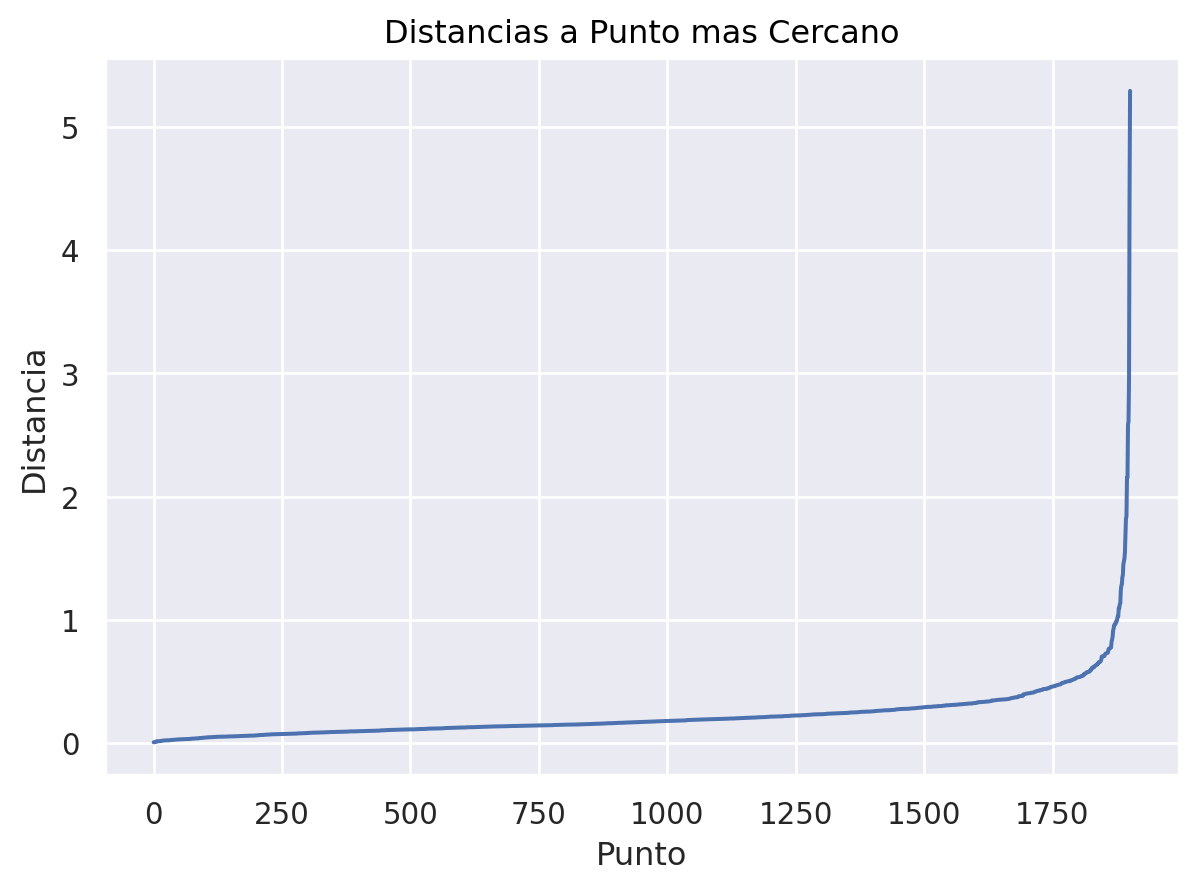

In [11]:
vecinos  = NearestNeighbors(n_neighbors=2) #Ponemos 2 porque la funcion incluye al punto mismo desde donde esta mirando
distancias, ind = vecinos.fit(CompPrincipales).kneighbors(CompPrincipales)
distancias = distancias[:,1]
distancias = np.sort(distancias,axis=0)

so.Plot(x = np.arange(len(distancias)),y = distancias).add(so.Line()).label(y = "Distancia",x = "Punto").label(title = "Distancias a Punto mas Cercano")

Recordemos que las distancias son tan pequeñas porque estamos trabajando sobre los datos escalados .

Basados en el grafico, vamos a elegir epsilon = 1

Ahora para seleccionar el otro hiperparametro, vamos a buscar para cada punto, cuantos otros puntos con distancia menor a epsilon tienen.
Luego tomaremos el promedio como nuestra eleccion de minPts

In [12]:
#Usamos esta funcion porque necesitamos computar rapidamente la distancia de todos a todos
#Cuando lo intentamos programar a mano, el tiempo de computo era irrazonable
from scipy.spatial.distance import cdist;

def puntos_por_epsilon(X, epsilon:int):
    #Lo escribimos de esta manera tan generica, ya que luego lo usareoms para puntos de n-dimensiones

    distancias = cdist(X.values,X.values)
    
    cantidad = np.sum(distancias < epsilon,axis=1) - 1  #Restamos uno para no contar al punto mismo
    
    
    return cantidad

rango = 1
cercanos = puntos_por_epsilon(CompPrincipales,rango)
cercanosAVG = cercanos.mean()
cercanosSTD = cercanos.std()

print("La cantidad de puntos-media a una distancia menor o igual a {0} en el dataset es de {1:0.2f}, con una desviacion estandar de {2:0.2f}".format(rango,cercanosAVG,cercanosSTD))

La cantidad de puntos-media a una distancia menor o igual a 1 en el dataset es de 25.05, con una desviacion estandar de 14.25


Obtuvimos nuestro promedio, y la desviacion estandar parece ser razonable. Como es claro que no podemos tomar una cantidad no entera de minPts, elegimos 10 como nuestro hiperparamentro.
Ahora si realizamos el DBSCAN y el grafico con el clustering resultante

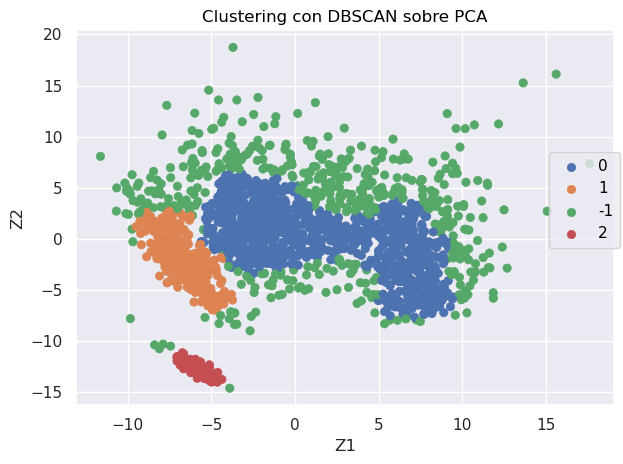

In [13]:
agrupamiento = DBSCAN(eps = 1,min_samples=25)
etiquetas = agrupamiento.fit_predict(CompPrincipales)

so.Plot(CompPrincipales, x = "Z1",y ="Z2",color = etiquetas.astype("str")).add(so.Dot()).label(title= "Clustering con DBSCAN sobre PCA").show()


Exito! Parece que identifica apropiadamente a los 3 clusters que podiamos observar en el grafico original

e) Utilizar DBSCAN para realizar agrupamiento utilizando como datos todas las variables
originales en vez de solo las dos componentes principales, modificando los valores de
epsilon y minPts convenientemente. ¿Con cuál de las dos opciones obtienen mejores
resultados?

Usaremos el mismo procedimiento para obtener nuestros hiperparametros
1ero Buscamos el epsilon con el metodo del codo

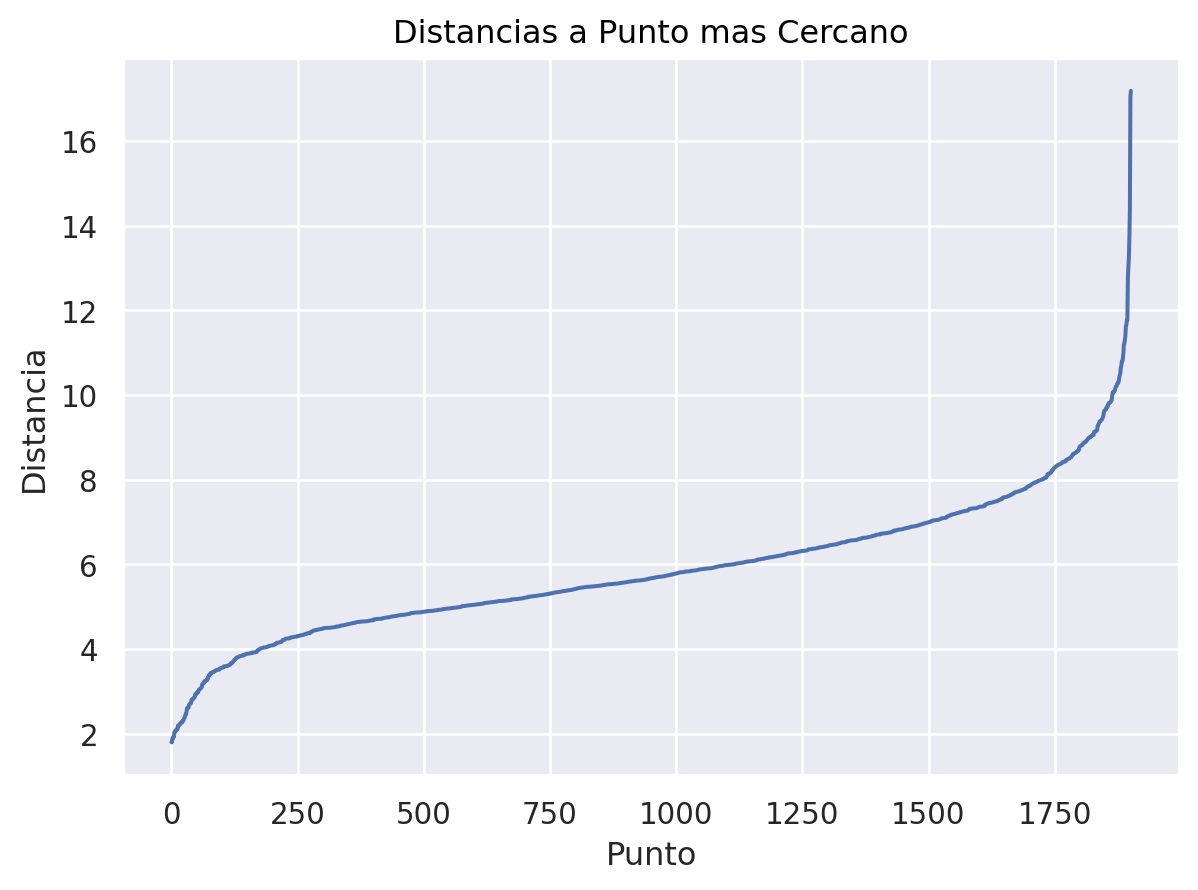

In [14]:
vecinos  = NearestNeighbors(n_neighbors=2) #Ponemos 2 porque la funcion incluye al punto mismo desde donde esta mirando
#Primero escalamos todos los datos, les damos media 0 y varianza 1

col = data_num.columns.tolist()
data_num_star = StandardScaler().fit_transform(data_num)
data_num_star = pd.DataFrame(data_num_star,columns=col)

distancias, ind = vecinos.fit(data_num_star).kneighbors(data_num_star)
distancias = distancias[:,1]
distancias = np.sort(distancias,axis=0)

so.Plot(x = np.arange(len(distancias)),y = distancias).add(so.Line()).label(y = "Distancia",x = "Punto").label(title = "Distancias a Punto mas Cercano")

Elejimos epsilon = 10. Buscamos ahora minPts

In [15]:
rango = 8
cercanosAVG = puntos_por_epsilon(data_num_star,rango).mean()

print("La cantidad de puntos-media a una distancia menor o igual a {0} en el dataset original es de {1}".format(rango,cercanosAVG))

La cantidad de puntos-media a una distancia menor o igual a 8 en el dataset original es de 89.4521556256572


Realizamos el agrupamiento con los hiperparametros encontrados y graficamos sobre el agrupamiento PCA anteriormente realizado

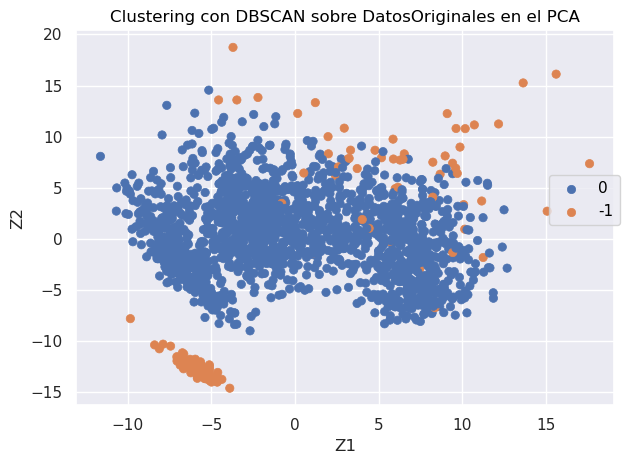

In [16]:
agrupamiento = DBSCAN(eps = 10,min_samples=89)
etiquetas = agrupamiento.fit_predict(data_num_star)

so.Plot(CompPrincipales, x = "Z1",y ="Z2",color = etiquetas.astype("str")).add(so.Dot()).label(title= "Clustering con DBSCAN sobre DatosOriginales en el PCA").show()

Parece que solo nos da un unico cluster, no considera aquellos valores que *en el PCA* son outliers

### 3. Clasificación

7. Ahora queremos poder predecir la posición en la que juega cada jugador según sus datos
estadísticos utilizando K-NN . En la columna Pos encontramos la posición de los jugadores.
Para la mayoría de los jugadores se indica una única posición pero algunos jugadores tienen
dos posiciones. Para simplificar el análisis vamos a considerar una única posición por jugador.

(a) Definir la variable Pos_filt que es la columna Pos, pero donde los jugadores deben tener
una sola posición (pueden quedarse sólo con la primera posición de cada jugador o eliminar
los jugadores con dos posiciones, lo que consideren más conveniente).

In [17]:
Pos_filt = FBRef["Pos"]
#Nos quedamos solo con la primera posicion en el caso de tener mas de una
Pos_filt = [x.split(",")[0] for x in Pos_filt]

(b) Construir el DataFrame data_clasif que resulta de agregarle la columna de Pos_filt
al DataFrame data_num. Dividir data_num en un 80% para entrenamiento y un 20% para
testeo.

In [18]:
data_clasif = data_num
data_clasif["Pos_filt"] = Pos_filt
data_clasif_train,data_clasif_test = train_test_split(data_clasif,test_size=0.2)
display(data_clasif.head())

,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,FKSht/90,np:G-xG,...,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90,Pos_filt
0,0.05,0.00,0.05,0.04,0.06,0.10,0.91,0.30,0.15,-0.06,...,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34,DF
1,0.00,0.09,0.09,0.01,0.05,0.06,0.47,0.16,0.00,0.04,...,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22,DF
2,0.00,0.00,0.00,0.00,0.08,0.09,0.93,0.21,0.00,-0.09,...,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00,DF
3,0.00,0.07,0.07,0.03,0.05,0.08,0.66,0.15,0.00,0.02,...,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59,DF
4,0.03,0.00,0.03,0.03,0.03,0.06,0.26,0.00,0.00,-0.03,...,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70,DF


(c) Aplicar un esquema de validación en el conjunto de entrenamiento para seleccionar el valor óptimo de K. 


Vamos a utilizar un esquema de validacion de train y test sobre nuestro dataset, tomando valores de k desde 0 hasta 20

In [19]:
from sklearn.preprocessing import LabelEncoder
#Usamos esta funcion de sklearn para convertir nuestras posiciones de jugadores categorias a una correspondencia numerica
#Encodeamos la respuesta a un numero
X_train = data_clasif_train.drop(columns = "Pos_filt")
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(data_clasif_train["Pos_filt"])
y_test_encoded = label_encoder.transform(data_clasif_test["Pos_filt"])
X_test = data_clasif_test.drop(columns = "Pos_filt")

In [20]:

maxK  = 20
#Le damos un lugar mas ya  que queremos que exista el indice final
aciertosTesting = np.zeros(maxK+1)

for K in range(1,maxK+1):

    myKNN = KNeighborsClassifier(n_neighbors=K) #K Empieza en 1

   
    myKNN.fit(X_train,y_encoded_train)
    y_pred = myKNN.predict(X_test)
    

    aciertosTesting[K] = accuracy_score(y_pred,y_test_encoded)
print("El mejor resultado se obtiene cuando elegimos que K sea igual a {0}".format(aciertosTesting.argmax()))

El mejor resultado se obtiene cuando elegimos que K sea igual a 13


d) Para el valor de K obtenido, ¿cuál es el porcentaje de aciertos en el conjunto de testeo?

Hagamos algo un poco mas lindo, visualizemos todos los resultados!

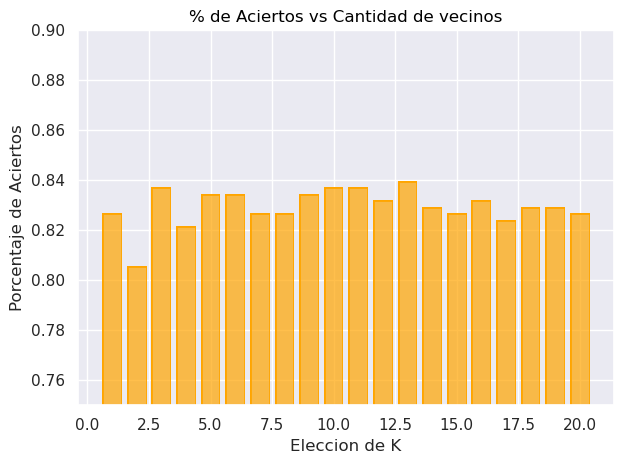

El porcentaje de maximo acierto es de 83.99% con K = 13


In [21]:
bestK = aciertosTesting.argmax()
so.Plot(x = np.arange(0,len(aciertosTesting)),y =aciertosTesting).add(so.Bar(color="orange")).limit(y = (0.75,0.9)).label(x= "Eleccion de K" ,y = "Porcentaje de Aciertos",title="% de Aciertos vs Cantidad de vecinos").show()
print("El porcentaje de maximo acierto es de {0:0.2f}% con K = {1}".format(aciertosTesting[bestK]*100,bestK))

Se observa que a pesar de que hay un K con resultados maximos el data set no es particularmente sensible a la eleccion de K's (notar la escala del eje y)

e) Repetir el procedimiento utilizando la primeras dos componentes principales en vez de
todas las variables. Indicar si se obtienen mejores resultados.

In [22]:
myPCA = PCA(n_components=2)
X_pca_train = myPCA.fit_transform(X_train)
X_pca_test = myPCA.transform(X_test)

maxK  = 20
#Le damos un lugar mas ya  que queremos que exista el indice final
aciertosTesting = np.zeros(maxK+1)

for K in range(1,maxK+1):

    myKNN = KNeighborsClassifier(n_neighbors=K) #K Empieza en 1

   
    myKNN.fit(X_pca_train,y_encoded_train)
    y_pred = myKNN.predict(X_pca_test)
    

    aciertosTesting[K] = accuracy_score(y_pred,y_test_encoded)

bestK = aciertosTesting.argmax()

print("El porcentaje de maximo acierto es de {0:0.2f}% con K = {1}".format(aciertosTesting[bestK]*100,bestK))


El porcentaje de maximo acierto es de 79.79% con K = 20


Los resultados no parecen mejorar cuando hacemos el analisis sobre PCA

8. Repetir el mismo método de clasificación con el dataset de jugadoras de la liga inglesa femenina superleague2023.csv. Para esto, quedarse con la columna Pos y las columnas a partir de MP, inclusive. ¿Qué porcentaje de aciertos obtienen en este caso? ¿Puede modificarse el parámetro para obtener un porcentaje mayor?

Para este punto vamos a rehacer varias veces la prueba de validacion de k-nn, a fin de no repetir codigo, creamos una funcion para que lo reproduzca

In [23]:
def K_NNTesting(maxK:int,X_train,X_test,y_train,y_test) -> np.array:

    #Le damos un lugar mas ya  que queremos que exista el indice final
    aciertosTesting = np.zeros(maxK+1)

    for K in range(1,maxK+1):

        myKNN = KNeighborsClassifier(n_neighbors=K) #K Empieza en 1

   
        myKNN.fit(X_train,y_train)
        y_pred = myKNN.predict(X_test)
    

        aciertosTesting[K] = accuracy_score(y_pred,y_test)
    return aciertosTesting


Primero realizamos un preprocesado similar a la de los puntos anteriores

In [24]:
data_fem = pd.read_csv("superleague2023.csv")
pos_fem = data_fem["Pos"]
#Nos quedamos solo con la primera posicion en el caso de tener mas de una
pos_fem = [x.split(",")[0] for x in pos_fem]

#Recuperamos el indice de la primera columna que queremos  que este
indiceInicioCol = FBRef.columns.get_loc("MP")

#Cortamos el dataset en base a este indice
data_fem_f = data_fem.iloc[:,indiceInicioCol:]
data_fem_f["Pos"] = pos_fem

#Convertimos columna Min de int a string, para poder usarla en el analisis
strToInt= lambda x: int(x.replace(",",""))

data_fem_f["Min"] = [strToInt(x) for x in data_fem_f["Min"]]

display(data_fem_f.head())

,MP,Starts,Min,90s,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,Per90Minutes_Ast,Per90Minutes_G+A,Per90Minutes_G-PK,Per90Minutes_G+A-PK,Per90Minutes_xG,Per90Minutes_xAG,Per90Minutes_xG+xAG,Per90Minutes_npxG,Per90Minutes_npxG+xAG,Pos
0,11,0,87,1.0,0,1,1,0,0,0,...,1.03,1.03,0.0,1.03,0.03,0.00,0.03,0.03,0.03,MF
1,1,0,6,0.1,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,FW
2,1,0,1,0.0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,MF
3,16,10,923,10.3,1,2,3,1,0,0,...,0.20,0.29,0.1,0.29,0.04,0.12,0.15,0.04,0.15,MF
4,6,4,296,3.3,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.06,0.00,0.06,0.06,0.06,DF


Ahora si , realizamos el fitting de k-nn, explorando multiples valores para k

In [25]:

data_fem_train,data_fem_test = train_test_split(data_fem_f,test_size=0.2,random_state= 276)

X_train = data_fem_train.drop(columns = ["Pos"])
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(data_fem_train["Pos"])
y_test_encoded = label_encoder.transform(data_fem_test["Pos"])
X_test = data_fem_test.drop(columns = "Pos")

aciertosTesting = K_NNTesting(20,X_train,X_test,y_encoded_train,y_test_encoded)

bestK = aciertosTesting.argmax()
print("El porcentaje de maximo acierto es de {0:0.2f}% con K = {1}".format(aciertosTesting[bestK]*100,bestK))


El porcentaje de maximo acierto es de 45.90% con K = 2


Grafiquemos nuestros resultados nuevamente para ver la distribucion

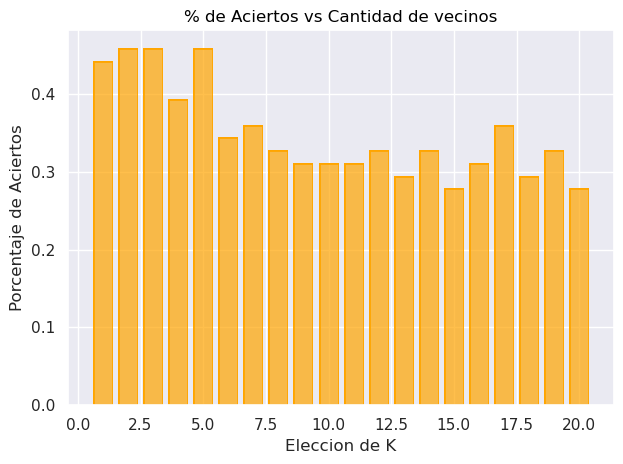

In [26]:

so.Plot(x = np.arange(0,len(aciertosTesting)),y =aciertosTesting).add(so.Bar(color="orange")).label(x= "Eleccion de K" ,y = "Porcentaje de Aciertos",title="% de Aciertos vs Cantidad de vecinos").show()

Parece que la prediccion es bastante peor que en la liga de los jugadores masculinos, no parece que podamos pasar del 40%. ¿No obstante habra algo que podamos hacer para mejorarlo?

Mientras realizabamos esta parte del trabajo, notamos que si excluiamos a la variable minutos como factor(que tanto nos costo convertir a valor numerico en el preprocesado), los resultados de clasificacion  mejoraban notoramiente.

In [27]:
X_train_star = X_train.drop(columns= "Min")
X_test_star = X_test.drop(columns = "Min")
aciertosTesting_noMin =  K_NNTesting(20,X_train_star,X_test_star,y_encoded_train,y_test_encoded)
bestK = aciertosTesting_noMin.argmax()

print("El porcentaje de maximo acierto es de {0:0.2f}% con K = {1}".format(aciertosTesting_noMin[bestK]*100,bestK))


El porcentaje de maximo acierto es de 78.69% con K = 4


Obtuvimos un mucho mejor resultado!  Nuestra hipotesis es que la cantidad de minutos jugados en un partido no esta fuertemente relacionada con la posicion en la que cada jugador se desempeña. Grafiquemos como cambia el porcentaje de acierto en ambos casos para visualizarlo mejor

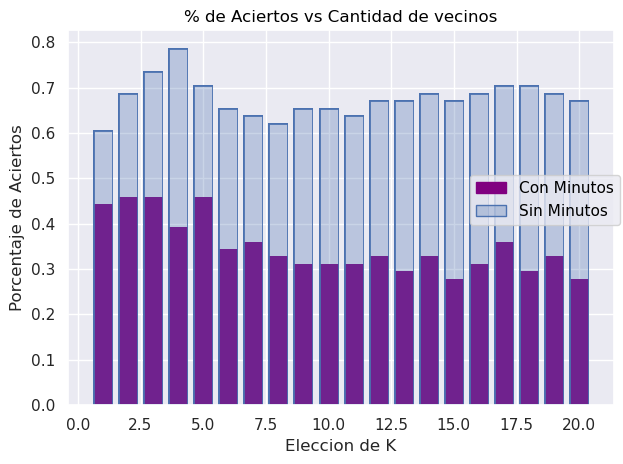

In [28]:

(so.Plot(x = np.arange(0,len(aciertosTesting)))
 .add(so.Bar(color="purple",alpha=1),y = aciertosTesting,label= "Con Minutos")
 .add(so.Bar(alpha=0.3), y = aciertosTesting_noMin,label = "Sin Minutos")
 .label(x= "Eleccion de K" ,y = "Porcentaje de Aciertos",title="% de Aciertos vs Cantidad de vecinos").show()
)

### 4. Recomendaciones de Jugadores

Trabajamos ahora con el dataset transfermarkt_fbref_201920.csv que incluye la valuación de los jugadores. Una de las aplicaciones m´as comunes de análisis de datos en el fútbol es para obtener recomendaciones de jugadores a comprar.

In [29]:
data = pd.read_csv("transfermarkt_fbref_201920.csv",delimiter= ";")
display(data.head())


,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
0,21,Martin Aguirregabiria,es ESP,DF,Alavés,23,1996,4000000,178,Defender - Right-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
1,390,Oliver Burke,sco SCO,"MF,FW",Alavés,22,1997,4000000,188,Forward - Right Winger,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
2,430,Ví­ctor Camarasa,es ESP,MF,Alavés,25,1994,4000000,183,Midfielder - Central Midfield,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
3,737,Rubén Duarte,es ESP,DF,Alavés,23,1995,4000000,172,Defender - Left-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
4,770,Rodrigo Ely,br BRA,DF,Alavés,25,1993,1000000,188,Defender - Centre-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#


(a) En 2021 Messi fue transferido del Barcelona al PSG. Básandose en los datos disponibles, recomendarle a Barcelona un jugador de características similares a Messi pero de menor valor

El criterio para decidir el jugador sera el siguiente
- Consideraremos unicamente jugadores que jueguen los dos  mismos roles que messi (MF,FW)
- Vamos a escalar todas las variables numericas(ignorando algunas variables elegidas ad-hoc, como el valor de mercado) y buscar al jugador que este mas "cerca" a messi en nuestro espacio n-dimensional

In [30]:
posMessi = data[data["player"].str.contains("Messi")].position
indMessi = data[data["player"].str.contains("Messi")].index


#Lo transformamos de serie a string
posMessi = ",".join(posMessi)

candidatos  = data[(data["position"] == posMessi)]

#Tiramos todos los datos restantes que no sean numericos (int o floats)
espacioBusqueda = candidatos.drop(columns = candidatos.select_dtypes(exclude=['float','int']).columns)
#Sacamos las variables que no queremos considerar
espacioBusqueda = espacioBusqueda.drop(columns=["Column1","birth_year","value"])
espacioBusqueda = espacioBusqueda.dropna()

#Escalamos todos los datos antes de buscar al mas cercano, pero queremos preservar los indices originales para poder recuperar el nombre del mas cercano
ind_og= espacioBusqueda.index


espacioBusqueda_escalado = StandardScaler().fit_transform(espacioBusqueda)

# Recreamos el dataFrame con los indices originales
espacioBusqueda_escalado = pd.DataFrame(espacioBusqueda_escalado, columns=espacioBusqueda.columns, index=ind_og)


NN = NearestNeighbors(n_neighbors=2).fit(espacioBusqueda_escalado)
distancias,ind = NN.kneighbors(espacioBusqueda_escalado.loc[indMessi])


posRecomendado = ind[0][1]

jugadorRecomendado = candidatos.iloc[posRecomendado].player
print(jugadorRecomendado)


Ángel Di Marí­a


Exitos! Obtuvimos a Angel Di María como mejor reemplazo para Messi. Viva la argentidad!!

(b) Queremos elaborar un modelo para detectar jugadores “baratos”, es decir cuya valuación en el mercado (columna value) sea inferior a que la que nosotros estimemos. Para esto, quisiéramos ajustar el valor de mercado a partir de los datos de los jugadores (para estimar
la valuación pueden incorporar la edad entre las variables explicativas). El modelo que desarrollen puede basarse en redes neuronales o en otro modelo que consideren adecuado.

Dado que tenemos muchisimos datos y para un modelo dado poder computar la solucion exacta puede ser muy caro, vamos a utilizar una red neuronal.

Nuestra red intentara darle un valor a los jugadores, dados algunos datos suyos sobre su desempeño. Luego de obtener esta resultado, vamos a tomar la salida del modelo y preguntar si es mayor o menor a su valor de mercado, en donde podremos determinar si es caro o barato respectivamente

Vamos a elegir los siguientes valores como input para nuestro modelo:
- age
- goals
- height
- assists
- passes_received
- carry_distance
- blocks
- minutes
- position

Es claro que los valores numericos pueden ser utilizados sin problemas. Pero queremos poder considerar tambien algunas variables categoricas.
En particular, nos interesa tener en cuenta las posiciones de los jugadores, ya que es bien sabido que esta afecta importantemente el precio. 

Usando One-Hot-Encoding podemos utilizar esta variable en nuestra red. 



In [31]:
#Primero preparamos nuestra input:
data = data.dropna()
encoder = OneHotEncoder()
columnas_Deseadas = ["player","value","age","goals","height","assists","passes_received","carry_distance","blocks","minutes"]
#Nos quedamos solo con la primera posicion en el caso de tener mas de una
Pos_filt = data["position"]
#Nos quedamos solo con la primera posicion en el caso de tener mas de una
Pos_filt = [x.split(",")[0] for x in Pos_filt]

data["position"] = Pos_filt
data =  data.reset_index(drop=True)

columnas_encoder  = encoder.fit_transform(data.position.values.reshape(-1,1)).toarray()


#Dropeamos todos los valores no numericos:   
df_Red = data[columnas_Deseadas]
df_Red  = pd.concat([
    df_Red,
    pd.DataFrame(columnas_encoder,columns=encoder.categories_[0])],axis=1)

df_Red["player"] = data["player"]
display(df_Red.head())

,player,value,age,goals,height,assists,passes_received,carry_distance,blocks,minutes,DF,FW,GK,MF
0,Martin Aguirregabiria,4000000,23,1,178,1,608,3313,39,2099,1.0,0.0,0.0,0.0
1,Oliver Burke,4000000,22,1,188,2,356,2795,25,1429,0.0,0.0,0.0,1.0
2,Ví­ctor Camarasa,4000000,25,0,183,1,432,2401,16,1293,0.0,0.0,0.0,1.0
3,Rubén Duarte,4000000,23,0,172,1,730,3688,62,2663,1.0,0.0,0.0,0.0
4,Rodrigo Ely,1000000,25,2,188,0,544,2576,38,2121,1.0,0.0,0.0,0.0


Ahora que tenemos nuestro data_set preprocesado, vamos a inicializar nuestra red

In [32]:
keras.utils.set_random_seed(320) #Especificamos la semilla para poder reproducir los resultados sobre multiples instancias

inputScaler = MinMaxScaler()
outputScaler = MinMaxScaler().set_output(transform="pandas")
X = df_Red.drop(columns = ["player","value"])
X = inputScaler.fit_transform(X)
y = df_Red["value"]
y = outputScaler.fit_transform(pd.DataFrame(y))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 242)

#Especificamos la arquitectura de la red
modelo = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)), #Especificamos las capas de entrada

    keras.layers.Dense(1,activation="sigmoid") # Una sola capa de salida: el Precio. Utilizamos la funcio sigmoidea como activacion
])

#Configuramos el optimizador
optimizer  = keras.optimizers.SGD(learning_rate=0.3)

#Construioms el modelo
modelo.compile(optimizer = optimizer,
               loss = "mean_squared_error",
            )



Ahora si! Entrenamos a nuestro modelo *Advertencia, dado que tenemos 150 epocas esto puede tardar un poco*

In [33]:

hist  = modelo.fit(X_train,y_train,
           epochs=150,
           batch_size= 20,
           validation_split=0.2,
           verbose=0,
           )

modelo.evaluate(X_test, y_test,
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )


{'loss': 0.00471181096509099}

Usamos ahora una funcion para graficar el error a traves de las epocas, junto con un grafico que compara las predicciones con los valores reales de cada jugador

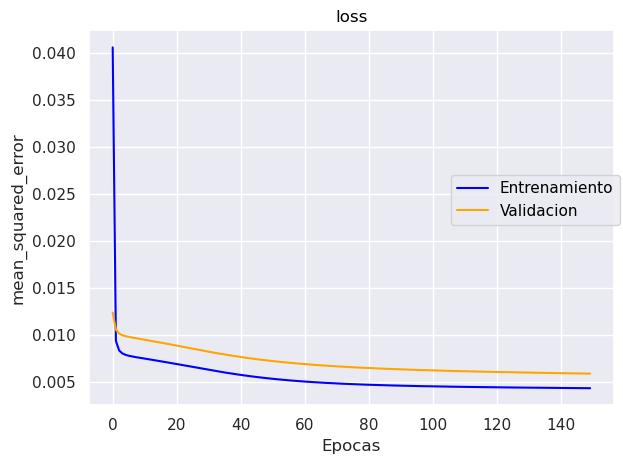

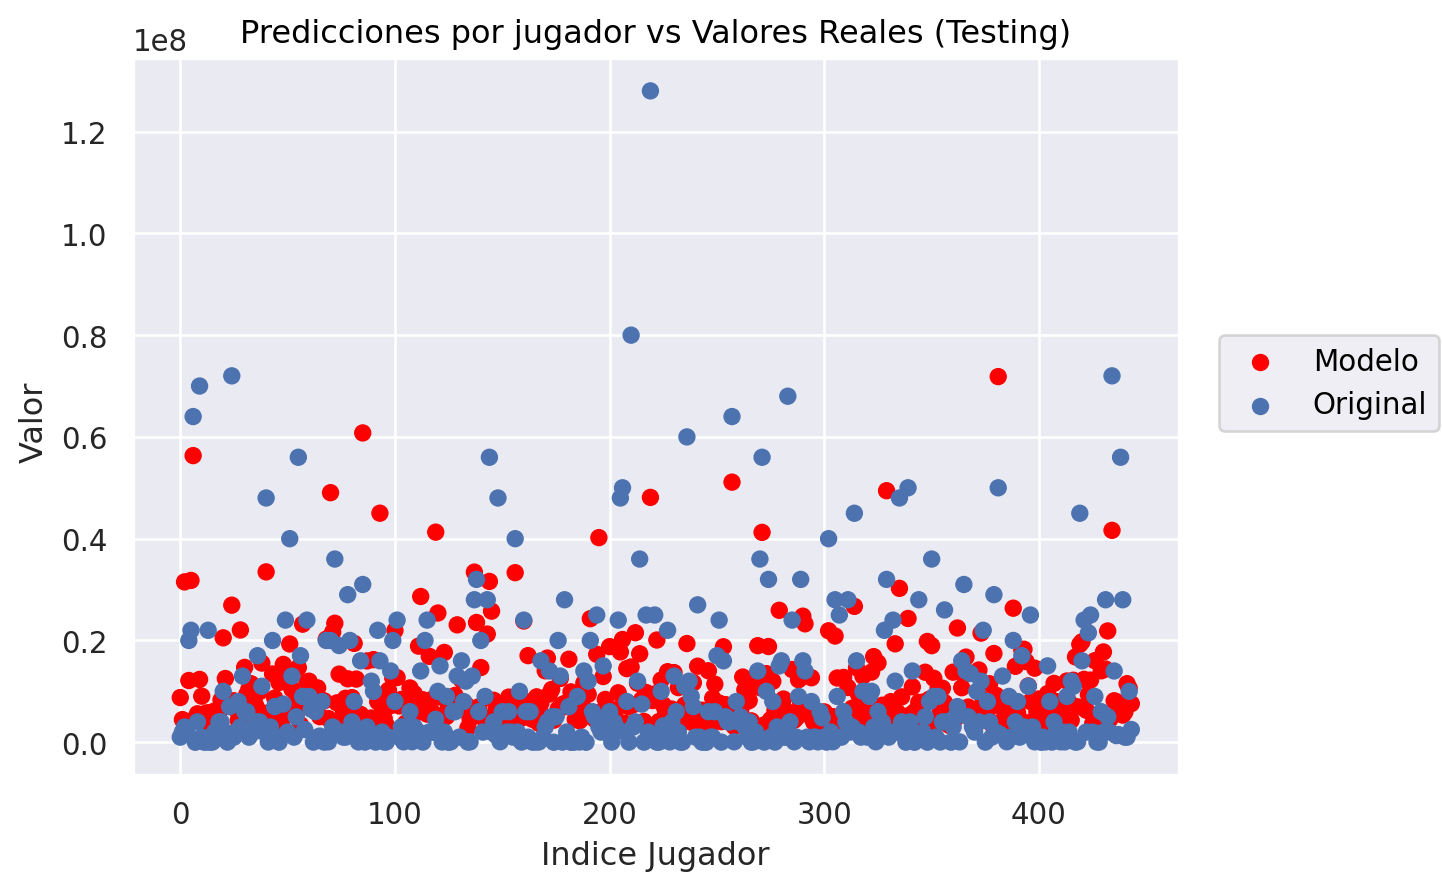

In [39]:
# Armamos una funcion para graficar el error a través de las épocas
def graficar_error(history, error_name):
    x_arr = np.array(history.epoch)    # en el atributo epoch, history guarda una lista de epocas
    plot = (
        so.Plot()
        .add(so.Line(color='blue'), x=x_arr, y=history.history[error_name], label='Entrenamiento')
        .add(so.Line(color='orange'), x=x_arr, y=history.history[f'val_{error_name}'], label='Validacion')
        .label(title=error_name,x = "Epocas", y = "mean_squared_error")
    )
    plot.show()

pred  = outputScaler.inverse_transform(modelo(X_test))
og = outputScaler.inverse_transform(y_test)

graficar_error(hist,'loss')
og = og.ravel()
pred = pred.ravel()
#print(pred)
so.Plot().add(so.Dot(color = "red"), x = np.arange(0,len(pred)),y = pred,label="Modelo").add(so.Dot(), x = np.arange(0,len(pred)), y = og,label="Original").label(title = "Predicciones por jugador vs Valores Reales (Testing)", y = "Valor ", x ="Indice Jugador")

Vemos en nuestro grafico de errores, que el ECM tanto de validacion como de testing baja exitosamente con cada iteracion, dandonos una pista de que el modelo que elegimos esta bien encaminado

(c) Según el modelo desarrollado, entre los jugadores con un valor de mercado mayor a $100000, ¿quién es el más sobrevalorado? Es decir, el jugador con mayor diferencia entre el valor de mercado y el valor predicho por el modelo. ¿Y el más infravalorado?

Evaluemos en contra de nuestro modelo, busquemos la maxima y minima diferencia entre el resultado del modelo y los valores reales

In [35]:
jugadoresCaros = df_Red[df_Red["value"] > 100000]
valores_og = np.array(jugadoresCaros["value"])
#Escalamos para poder evaluar el modelo correctament
scaler = MinMaxScaler().set_output(transform="pandas")
X = jugadoresCaros.drop(columns = ["player","value"])
X = scaler.fit_transform(X)
pred = np.array(outputScaler.inverse_transform(modelo(X))).flatten()

#Todos los que estan subvalorados se van a negativo, asi que no nos afectan
Max_id = (valores_og - pred).argmax()
#Todos los que estan sobrevalorados son positivos, asi que no nos afectan
Min_id = (valores_og-pred).argmin()


print("El jugador mas sobrevalorado es {0} y el mas infravalorado es {1}".format(jugadoresCaros.loc[Max_id].player,jugadoresCaros.loc[Min_id].player))

El jugador mas sobrevalorado es Alessio Romagnoli y el mas infravalorado es John McGinn


d) El PSG quiere vender a Mbappé y reemplazarlo por otro jugador más barato. Hacer un listado de los 10 jugadores más parecidos a Mbappé según el criterio que elijan. De esos 10 jugadores, según el modelo que desarrollaron en el ítem anterior, ¿a qué jugador recomendarían teniendo en cuenta la valuación del mercado y la predicción del modelo? Para ese jugador, averiguar la valuación actual del jugador. ¿Hicieron una buena recomendación?

Vamos a utilizar la misma tecnica que usamos en el punto (a) para definir lo que es un jugador "parecido", pero esta vez quedandonos con los primeros 10 mas cercanos

In [36]:
posMbappe = data[data["player"].str.contains("Mbappé")].position
indMbappe = data[data["player"].str.contains("Mbappé")].index


#Lo transformamos de serie a string
posMbappe = ",".join(posMbappe)

candidatos  = data[(data["position"] == posMbappe)]

#Tiramos todos los datos restantes que no sean contables (int o floats)
espacioBusqueda = candidatos.drop(columns = candidatos.select_dtypes(exclude=['float','int']).columns)
#Sacamos las variables que no queremos considerar
espacioBusqueda = espacioBusqueda.drop(columns=["Column1","birth_year","value"])
espacioBusqueda = espacioBusqueda.dropna()

#Escalamos todos los datos antes de buscar al mas cercano, pero queremos preservar los indices originales para poder recuperar el nombre del mas cercano
ind_og= espacioBusqueda.index


espacioBusqueda_escalado = StandardScaler().fit_transform(espacioBusqueda)

# Recreamos el dataFrame con los indices originales
espacioBusqueda_escalado = pd.DataFrame(espacioBusqueda_escalado, columns=espacioBusqueda.columns, index=ind_og)


NN = NearestNeighbors(n_neighbors=11).fit(espacioBusqueda_escalado)
distancias,ind = NN.kneighbors(espacioBusqueda_escalado.loc[indMbappe])


posRecomendado = ind[0][1:] #no queremos que este mbappe asi que cortamos el primer elemento
jugadoresRecomendados = pd.DataFrame(candidatos.iloc[posRecomendado].player)
display(jugadoresRecomendados)


,player
161,Duván Zapata
1129,Joaquí­n Correa
264,Luis Suárez
1401,Sergio AgíĽero
1260,Moussa Diaby
273,Kingsley Coman
1075,Gonzalo Higuaí­n
1540,Rafael Leóo
585,Christian Pulisic
1411,Gabriel Jesus


Estos son nuestros 10 jugadores  "mas parecidos". Para hacer una recomendacion, vamos a buscar al que nuestro modelo le adjudica mayor valor.
Luego compararemos con el valor de mercado, para ver que tan buena fue nuestra recomendacion

In [37]:

dominioRed =  df_Red[df_Red["player"].isin(jugadoresRecomendados["player"])]
X = MinMaxScaler().fit_transform(dominioRed.drop(columns=["player","value"]))
pred = outputScaler.inverse_transform(modelo(X))
id_recomendado = pred.argmax()
print("Nuestra recomendación de jugador es {0}, con un valor de nuestro modelo de {1:.0f}, y su valor de mercado es {2}"
      .format(dominioRed.iloc[id_recomendado].player,pred[id_recomendado][0],dominioRed.iloc[id_recomendado].value))


Nuestra recomendación de jugador es Moussa Diaby, con un valor de nuestro modelo de 144002823, y su valor de mercado es 27000000


Curiosamente la recomendación es otro jugador frances, del equipo ingles Aston Villa 